In [1]:
from utils import get_images_full_path, load_groundtruth_illuminant
import configparser
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
def correct_color_single_image(img, illuminant):
    """
    Apply color correction via Von-Kries Model

    Args:
        img (np.array): input (linear) image
        illuminant (np.array): RGB  color of light source
    Returns:
        img_corr (np.array): corrected image s.t. to be
        taken under a canonical perfect white light source
    """
    highest_gain = np.max(illuminant)
    gain = highest_gain / illuminant
    img_corr = img.copy()
    for idx_channel in range(img.shape[2]):
        img_corr[:, :, idx_channel] = img_corr[:, :, idx_channel] * gain[idx_channel]

    return img_corr

def srgb_gamma(img):
    """
    Apply gamma correction (forward transformation)
    (https://en.wikipedia.org/wiki/SRGB)

    Args:
        img (np.array): input (linear) image
    Returns:
        img (np.array): non-linear/gamma-compressed image
    """

    for idx_channel in range(img.shape[2]):
        this_channel = img[:, :, idx_channel]
        img[:, :, idx_channel] = 12.92 * this_channel * (this_channel <= 0.0031308) + (
                    1.055 * this_channel ** (1 / 2.4) - 0.055) * (this_channel > 0.0031308)

    return img

In [3]:
shigehler_config = configparser.ConfigParser()
shigehler_config.read("assests/shigehler.cfg")
img_folder_path = shigehler_config["SHIGEHLER"]["DB_PATH"]
gt_file_path = shigehler_config["SHIGEHLER"]["REAL_RGB"]
original_bitdepth = int(shigehler_config["SHIGEHLER"]["ORIGINAL_BITDEPTH"])

In [4]:
db_images = get_images_full_path(img_folder_path)
db_images[:5]

['/Users/karanshah/Fall2023/courses/AdvCV/HW2/Color-Constancy-Research/data/png_canon1d/chroma/data/canon_dataset/568_dataset/png/8D5U5524.png',
 '/Users/karanshah/Fall2023/courses/AdvCV/HW2/Color-Constancy-Research/data/png_canon1d/chroma/data/canon_dataset/568_dataset/png/8D5U5525.png',
 '/Users/karanshah/Fall2023/courses/AdvCV/HW2/Color-Constancy-Research/data/png_canon1d/chroma/data/canon_dataset/568_dataset/png/8D5U5526.png',
 '/Users/karanshah/Fall2023/courses/AdvCV/HW2/Color-Constancy-Research/data/png_canon1d/chroma/data/canon_dataset/568_dataset/png/8D5U5527.png',
 '/Users/karanshah/Fall2023/courses/AdvCV/HW2/Color-Constancy-Research/data/png_canon1d/chroma/data/canon_dataset/568_dataset/png/8D5U5528.png']

In [5]:
real_rgb = load_groundtruth_illuminant(gt_file_path)

In [6]:
im_idx = np.random.choice(len(db_images), 8)
# im_idx = np.array([ 63, 527, 328, 176, 248, 277, 221, 368])

In [7]:
cnn_est_avg_pool_label = np.load("predictedAvgLabels.npz")["arr_0"]

In [8]:
input_imgs = []
gt_imgs = []
cnn_imgs = []



for idx in im_idx:
    img = cv2.imread(db_images[idx], cv2.IMREAD_UNCHANGED).astype(np.float64)
    img = img[:,:,::-1] # convert BGR to RGB
    img = cv2.resize(img, (512, 512))
    # subtract black level: For the Canon 5D the black level is 129 and
    # for the Canon 1D it is zero.
    if "canon5d" in db_images[idx]:
        img = np.maximum(img - 129, 0)
    gt_img = correct_color_single_image(img, real_rgb[idx, :])
    cnn_img = correct_color_single_image(img, cnn_est_avg_pool_label[idx, :])
    
    img = img / (2**original_bitdepth -1)
    img = srgb_gamma(img)
    input_imgs.append(img)
    
    gt_img = gt_img / (2**original_bitdepth -1)
    gt_img = srgb_gamma(gt_img)
    gt_imgs.append(gt_img)
    
    cnn_img = cnn_img / (2**original_bitdepth -1)
    cnn_img = srgb_gamma(cnn_img)
    cnn_imgs.append(cnn_img)
    
input_imgs = np.concatenate(input_imgs, axis=1)
gt_imgs = np.concatenate(gt_imgs, axis=1)
cnn_imgs = np.concatenate(cnn_imgs, axis=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'CNN corrected images')

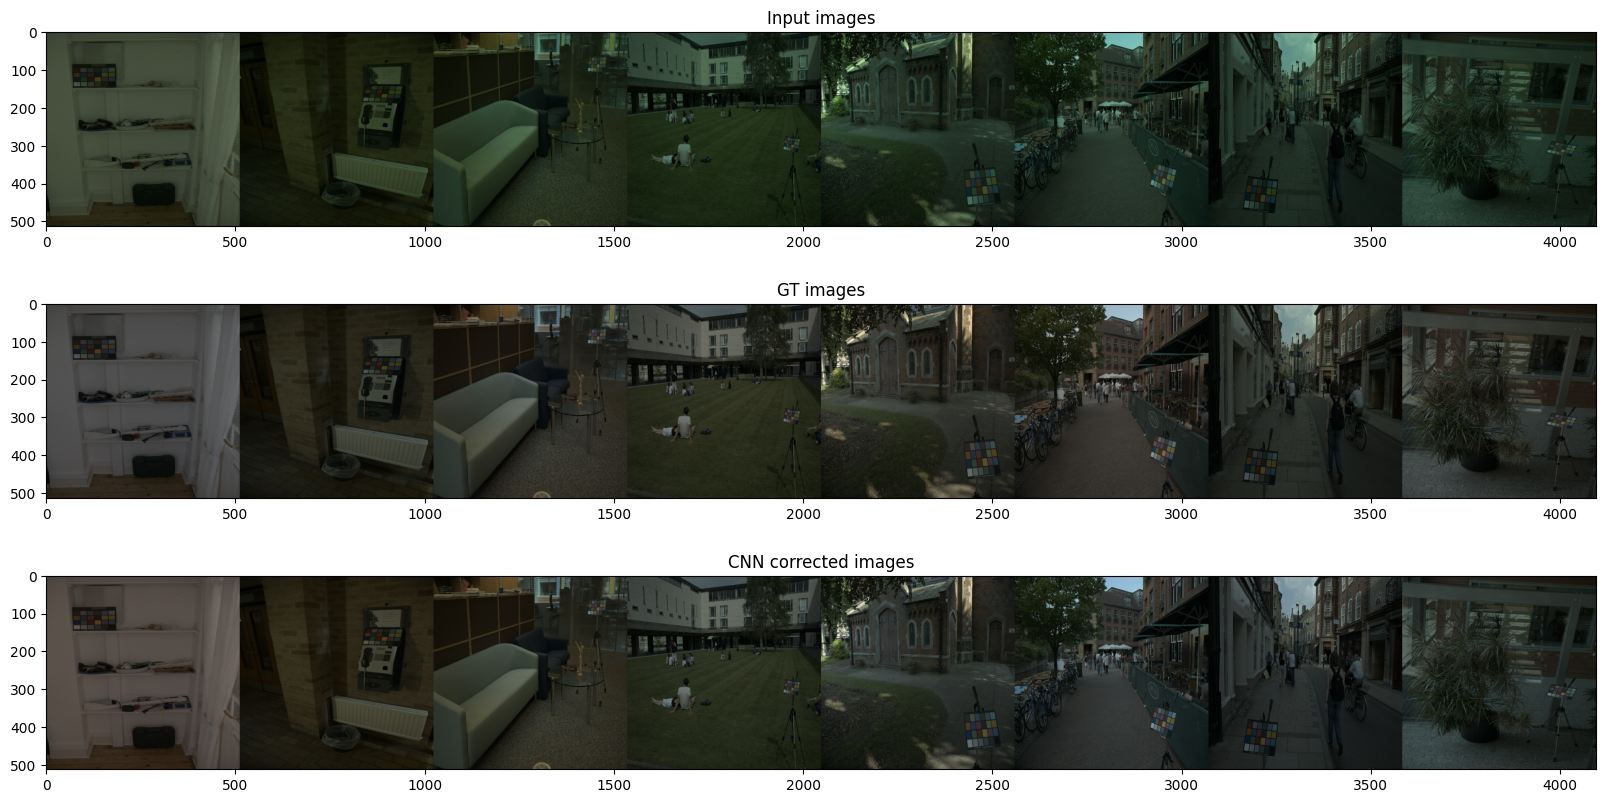

In [9]:
fig, ax = plt.subplots(3, 1, figsize=(20, 10))
ax[0].imshow(input_imgs)
ax[0].set_title('Input images')
ax[1].imshow(gt_imgs)
ax[1].set_title('GT images')
ax[2].imshow(cnn_imgs)
ax[2].set_title('CNN corrected images')
